In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!ls -lah '/content/drive/MyDrive/datasets/segmentation-buildings/'

total 8.0K
drwx------ 2 root root 4.0K Nov  3 19:42 Images
drwx------ 2 root root 4.0K Nov  3 19:42 Labels


In [ ]:
# @title
%%capture
!pip install patchify
!pip install -U -q segmentation-models

# Перезапуск среды выполнения
import os
os.kill(os.getpid(), 9)

In [31]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tqdm import tqdm

tf.compat.v1.enable_eager_execution()

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

from keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

env: SM_FRAMEWORK=tf.keras


In [49]:
train_img_dir = r'/content/drive/MyDrive/datasets/segmentation-buildings/Images/data'
train_mask_dir = r'/content/drive/MyDrive/datasets/segmentation-buildings/Labels/data'

In [50]:
img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(os.listdir(train_img_dir))

print(img_list, msk_list, num_images)

['Image_0.tif', 'Image_1.tif', 'Image_10.tif', 'Image_100.tif', 'Image_1000.tif', 'Image_1001.tif', 'Image_1002.tif', 'Image_1003.tif', 'Image_1004.tif', 'Image_1005.tif', 'Image_1006.tif', 'Image_1007.tif', 'Image_1008.tif', 'Image_1009.tif', 'Image_101.tif', 'Image_1010.tif', 'Image_1011.tif', 'Image_1012.tif', 'Image_1013.tif', 'Image_1014.tif', 'Image_1015.tif', 'Image_1016.tif', 'Image_1017.tif', 'Image_1018.tif', 'Image_1019.tif', 'Image_102.tif', 'Image_1020.tif', 'Image_1021.tif', 'Image_1022.tif', 'Image_1023.tif', 'Image_1024.tif', 'Image_1025.tif', 'Image_1026.tif', 'Image_1027.tif', 'Image_1028.tif', 'Image_1029.tif', 'Image_103.tif', 'Image_1030.tif', 'Image_1031.tif', 'Image_1032.tif', 'Image_1033.tif', 'Image_1034.tif', 'Image_1035.tif', 'Image_1036.tif', 'Image_1037.tif', 'Image_1038.tif', 'Image_1039.tif', 'Image_104.tif', 'Image_1040.tif', 'Image_1041.tif', 'Image_1042.tif', 'Image_1043.tif', 'Image_1044.tif', 'Image_1045.tif', 'Image_1046.tif', 'Image_1047.tif', 'Ima

<Figure size 1200x800 with 0 Axes>

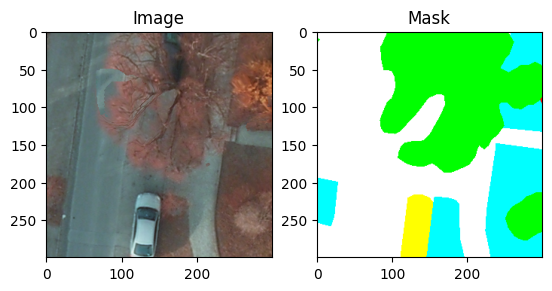

<Figure size 1200x800 with 0 Axes>

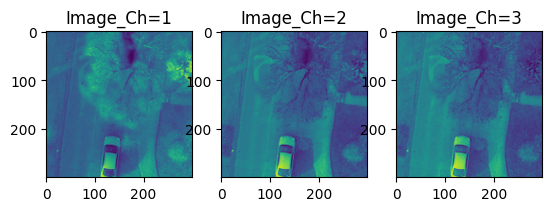

<Figure size 1200x800 with 0 Axes>

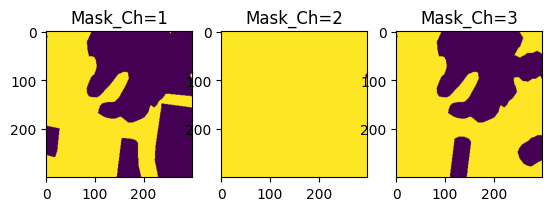

In [53]:
import random

img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(os.path.join(train_img_dir, img_list[img_num]))
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(os.path.join(train_mask_dir, msk_list[img_num]))
mask_for_plot = cv2.cvtColor(mask_for_plot, cv2.COLOR_BGR2RGB)

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

figure, axis = plt.subplots(1, 2)

axis[0].imshow(img_for_plot, cmap=plt.get_cmap('gray'),vmin=0,vmax=100)
axis[0].set_title('Image')

axis[1].imshow(mask_for_plot)
axis[1].set_title('Mask')

plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

figure, axis = plt.subplots(1, 3)

axis[0].imshow(img_for_plot[:,:,0])
axis[0].set_title('Image_Ch=1')

axis[1].imshow(img_for_plot[:,:,1])
axis[1].set_title('Image_Ch=2')

axis[2].imshow(img_for_plot[:,:,2])
axis[2].set_title('Image_Ch=3')

# Combine all the operations and display
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

figure, axis = plt.subplots(1, 3)

axis[0].imshow(mask_for_plot[:,:,0])
axis[0].set_title("Mask_Ch=1")

axis[1].imshow(mask_for_plot[:,:,1])
axis[1].set_title("Mask_Ch=2")

axis[2].imshow(mask_for_plot[:,:,2])
axis[2].set_title("Mask_Ch=3")

plt.show()


In [35]:
# Explore every clasees
# labels: {“roads”: "#ffffff", “buildings”: "#0000ff", “low veg”: "#00ffff", “trees”: "#00ff00", “cars”: "#ffff00", “clutter”: "#ff0000"}

# Define color scheme
COLOR_SCHEME = {
    'roads': (255, 255, 255),      # White
    'buildings': (0, 0, 255),       # Blue
    'low_veg': (0, 255, 255),       # Cyan
    'trees': (0, 255, 0),           # Green
    'cars': (255, 255, 0),          # Yellow
    'clutter': (255, 0, 0)          # Red
}

def analyze_class_distribution(label_dir, sample_size=None):
    """
    Analyze class distribution across all label patches

    Args:
        label_dir: Directory containing label files
        sample_size: If provided, only analyze this many random patches
    """

    # Get all label files
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.tif')])

    if sample_size and sample_size < len(label_files):
        print(f"Sampling {sample_size} patches out of {len(label_files)} total")
        import random
        label_files = random.sample(label_files, sample_size)

    print(f"Analyzing {len(label_files)} label patches...")

    # Initialize counters
    class_pixel_counts = {class_name: 0 for class_name in COLOR_SCHEME.keys()}
    total_pixels = 0

    # Track patches with each class
    patches_per_class = {class_name: 0 for class_name in COLOR_SCHEME.keys()}

    # Process each label file
    for label_file in tqdm(label_files, desc="Processing labels"):
        mask = cv2.imread(os.path.join(label_dir, label_file))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        patch_h, patch_w = mask.shape[:2]
        total_pixels += patch_h * patch_w

        # Count pixels for each class
        for class_name, color in COLOR_SCHEME.items():
            # Match pixels (with small tolerance for compression artifacts)
            match = np.all(np.abs(mask - color) <= 10, axis=-1)
            pixel_count = np.sum(match)

            class_pixel_counts[class_name] += pixel_count

            # Track if this patch contains this class
            if pixel_count > 0:
                patches_per_class[class_name] += 1

    # Calculate statistics
    print("\n" + "=" * 70)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("=" * 70)
    print(f"Total patches analyzed: {len(label_files)}")
    print(f"Total pixels: {total_pixels:,}")
    print(f"Patch dimensions detected: ~{int(np.sqrt(total_pixels/len(label_files)))}×{int(np.sqrt(total_pixels/len(label_files)))}")
    print("=" * 70)

    # Sort by pixel count
    sorted_classes = sorted(class_pixel_counts.items(),
                           key=lambda x: x[1],
                           reverse=True)

    print(f"\n{'Class':<15} {'Pixels':<15} {'Percentage':<12} {'Patches':<10}")
    print("-" * 70)

    results = {}
    for class_name, count in sorted_classes:
        percentage = (count / total_pixels) * 100
        patch_count = patches_per_class[class_name]
        patch_percentage = (patch_count / len(label_files)) * 100

        print(f"{class_name:<15} {count:>12,}   {percentage:>6.2f}%     "
              f"{patch_count:>4}/{len(label_files)} ({patch_percentage:>5.1f}%)")

        results[class_name] = {
            'pixel_count': int(count),
            'pixel_percentage': round(percentage, 2),
            'patches_with_class': patch_count,
            'patch_percentage': round(patch_percentage, 2)
        }

    print("=" * 70)

    # Check for class imbalance
    print("\n⚠️  CLASS IMBALANCE WARNINGS:")
    for class_name, stats in results.items():
        if stats['pixel_percentage'] < 1.0:
            print(f"  • {class_name}: Only {stats['pixel_percentage']}% - Very rare! "
                  f"May need special handling")
        elif stats['pixel_percentage'] < 5.0:
            print(f"  • {class_name}: Only {stats['pixel_percentage']}% - Rare class, "
                  f"will need class weighting")

    return results

results = analyze_class_distribution(train_mask_dir, sample_size=None)

Analyzing 2400 label patches...


Processing labels: 100%|██████████| 2400/2400 [01:52<00:00, 21.31it/s]


CLASS DISTRIBUTION ANALYSIS
Total patches analyzed: 2400
Total pixels: 216,000,000
Patch dimensions detected: ~300×300

Class           Pixels          Percentage   Patches   
----------------------------------------------------------------------
roads             61,865,104    28.64%     2020/2400 ( 84.2%)
buildings         59,012,566    27.32%     1542/2400 ( 64.2%)
low_veg           51,511,361    23.85%     1893/2400 ( 78.9%)
trees             27,248,806    12.62%     1420/2400 ( 59.2%)
clutter           12,479,736     5.78%     1168/2400 ( 48.7%)
cars               3,882,427     1.80%      833/2400 ( 34.7%)

⚠️  CLASS IMBALANCE WARNINGS:
  • cars: Only 1.8% - Rare class, will need class weighting


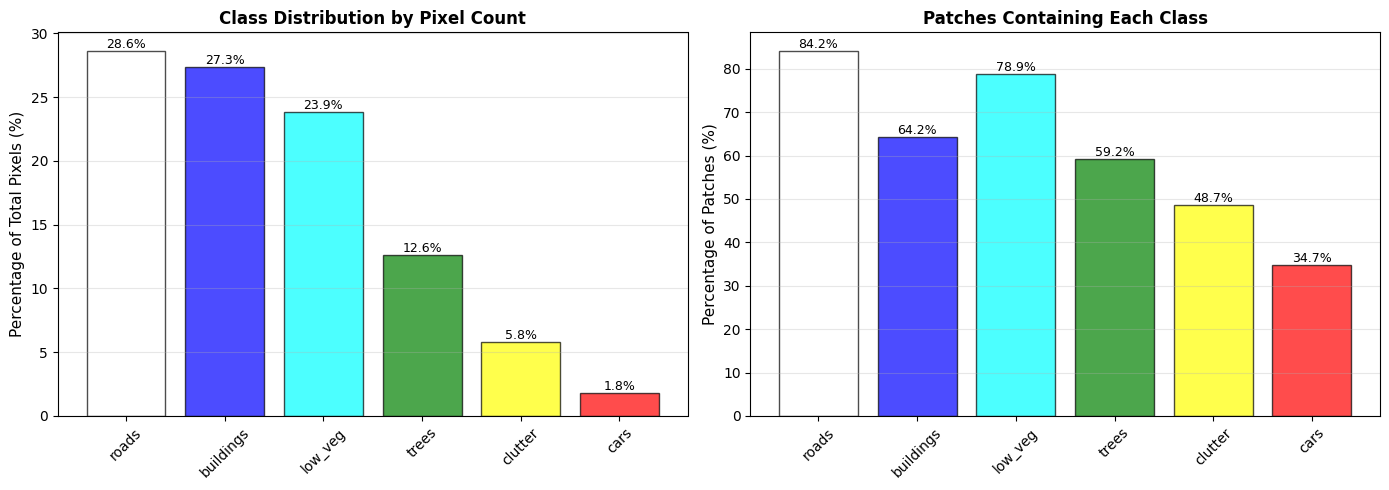

In [36]:
def create_distribution_plot(results):
    """Create visualization of class distribution"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Pixel percentage
    classes = list(results.keys())
    percentages = [results[c]['pixel_percentage'] for c in classes]
    colors = ['white', 'blue', 'cyan', 'green', 'yellow', 'red']

    bars1 = ax1.bar(classes, percentages, color=colors, edgecolor='black', alpha=0.7)
    ax1.set_ylabel('Percentage of Total Pixels (%)', fontsize=11)
    ax1.set_title('Class Distribution by Pixel Count', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # Add percentage labels on bars
    for bar, pct in zip(bars1, percentages):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

    # Plot 2: Patches containing each class
    patch_percentages = [results[c]['patch_percentage'] for c in classes]
    bars2 = ax2.bar(classes, patch_percentages, color=colors, edgecolor='black', alpha=0.7)
    ax2.set_ylabel('Percentage of Patches (%)', fontsize=11)
    ax2.set_title('Patches Containing Each Class', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

    # Add labels
    for bar, pct in zip(bars2, patch_percentages):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

create_distribution_plot(results)

In [37]:
def rgb_to_2D_label(label):
    """
    Замена значений каждого пикселя маски в формате RGB на целое число
    """

    # Если маска трехмерная, оставляем только первые три канала (RGB)
    if len(label.shape) == 3:
        label = label[:,:,:3]
    # Если маска четырехмерная, оставляем только первые три канала (RGB) каждого изображения
    if len(label.shape) == 4:
        label = label[:,:,:,:3]

    # Создаем новую маску той же формы, что и исходная
    label_seg = np.zeros(label.shape,dtype=np.uint8)

    # Присваиваем каждому пикселю значение в зависимости от его цвета
    label_seg [np.all(label == COLOR_SCHEME['roads'],axis=-1)] = 0
    label_seg [np.all(label==COLOR_SCHEME['buildings'],axis=-1)] = 1
    label_seg [np.all(label==COLOR_SCHEME['low_veg'],axis=-1)] = 2
    label_seg [np.all(label==COLOR_SCHEME['trees'],axis=-1)] = 3
    label_seg [np.all(label==COLOR_SCHEME['cars'],axis=-1)] = 4
    label_seg [np.all(label==COLOR_SCHEME['clutter'],axis=-1)] = 5

    if len(label.shape) == 3:
        label_seg = label_seg[:,:,0]

    if len(label.shape) == 4:
        label_seg = label_seg[:,:,:,0]

    # Возвращаем преобразованную маску
    return label_seg


### Реализации функции для предобработки входных данных:

In [38]:
# Импортируем MinMaxScaler из библиотеки sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
# Импортируем функцию to_categorical из библиотеки keras.utils
from keras.utils import to_categorical

# Создаем объект MinMaxScaler для нормализации данных
scaler = MinMaxScaler()

# Задаем архитектуру сети для передачи обучения
BACKBONE = 'resnet34'

# Получаем функцию предварительной обработки для выбранной архитектуры сети
preprocess_input = sm.get_preprocessing(BACKBONE)

# Определяем функцию для предварительной обработки данных
def preprocess_data(img, mask, num_class):
    # Масштабируем пиксели изображения в диапазон от 0 до 1
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

    # Применяем функцию предварительной обработки к изображению
    img = preprocess_input(img)

    # Преобразуем маску из формата RGB в 2D-метку (256, 256, 3) -> (256, 256, 1)
    mask = rgb_to_2D_label(mask)

    # Преобразуем 2D-метку в бинарную матрицу (256, 256, 1) -> (256, 256, 6)
    mask = to_categorical(mask, num_class)

    # Возвращаем предварительно обработанное изображение и маску
    return (img, mask)


In [39]:
seed=24
batch_size=16
n_classes=6

In [100]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Определяем функцию-генератор для обучения
def trainGenerator(train_img_path, train_mask_path, num_class):

    # Задаем аргументы для генератора данных: включаем горизонтальное и вертикальное отражение
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)

    # Создаем генераторы данных для изображений и масок с заданными аргументами
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    # Генераторы читают изображения и маски из указанных директорий
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        color_mode = 'rgb',
        target_size=(256, 256),
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        color_mode = 'rgb',
        target_size=(256, 256),
        seed = seed)

    # Объединяем генераторы изображений и масок в один генератор
    train_generator = zip(image_generator, mask_generator)

    # Для каждой пары (изображение, маска) выполняем предварительную обработку и возвращаем результат
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [101]:
train_img_dir = r'/content/drive/MyDrive/datasets/segmentation-buildings/Images/'
train_mask_dir = r'/content/drive/MyDrive/datasets/segmentation-buildings/Labels/'
train_img_gen = trainGenerator(train_img_dir, train_mask_dir, num_class=6)

Found 2400 images belonging to 1 classes.
Found 2400 images belonging to 1 classes.


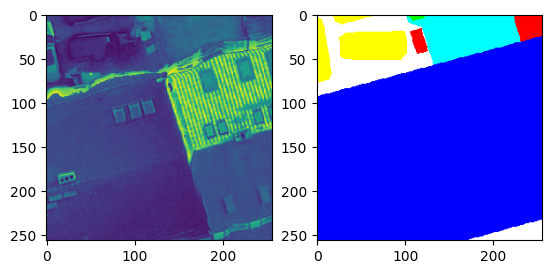

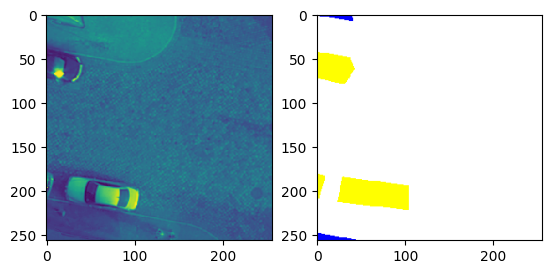

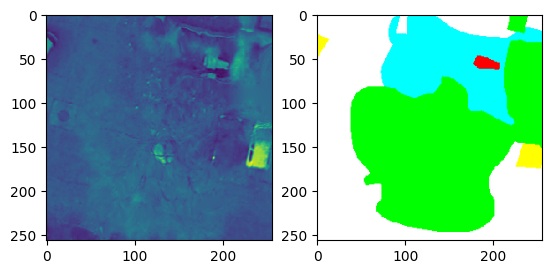

Unique labels in label dataset are:  [0 2 3 4 5]


In [102]:
from matplotlib.colors import ListedColormap

x, y = train_img_gen.__next__()

colors = [
    np.array(COLOR_SCHEME['roads'])/255,
    np.array(COLOR_SCHEME['buildings'])/255,
    np.array(COLOR_SCHEME['low_veg'])/255,
    np.array(COLOR_SCHEME['trees'])/255,
    np.array(COLOR_SCHEME['cars'])/255,
    np.array(COLOR_SCHEME['clutter'])/255,
]

cmap = ListedColormap(colors)

for i in range(0,3):
    image = x[i][:,:,0]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap=cmap, vmin=0, vmax=5)
    plt.show()

# x_val, y_val = val_img_gen.__next__()

# for i in range(0,3):
#     image = x_val[i][:,:,0]
#     mask = np.argmax(y_val[i], axis=2)
#     plt.subplot(1,2,1)
#     plt.imshow(image)
#     plt.subplot(1,2,2)
#     plt.imshow(mask)
#     plt.show()

labels, count = np.unique(mask, return_counts=True) #Check for each channel. All chanels are identical

print("Unique labels in label dataset are: ", np.unique(labels))

In [103]:
# Получаем количество изображений для обучения, подсчитывая количество файлов в указанной директории
num_train_imgs = len(os.listdir(r'/content/drive/MyDrive/datasets/segmentation-buildings/Images/data/'))
# num_val_images = len(os.listdir(r'/content/drive/MyDrive/Semantic segmentation dataset/Masks/val/'))

# Получаем количество шагов на эпоху, разделив количество изображений для обучения на размер пакета
steps_per_epoch = num_train_imgs//batch_size
# val_steps_per_epoch = num_val_images//batch_size


# Получаем высоту изображения
IMG_HEIGHT = x.shape[1]

# Получаем ширину изображения
IMG_WIDTH  = x.shape[2]

# Получаем количество каналов изображения
IMG_CHANNELS = x.shape[3]

# Задаем количество классов
n_classes=6

# Выводим полученные значения
print(num_train_imgs, steps_per_epoch, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
# print(num_train_imgs, num_val_images, steps_per_epoch, val_steps_per_epoch, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

2400 150 256 256 3
